#Part 5: DeepFool 

In [ ]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
deep_fool = DeepFool(wrap, sess=sess)

#Attack parameters
deep_fool_params = {'nb_candidate':10,
                    'max_iter':50,
                    'clip_min':0.,
                    'clip_max':1.}


#Generate adversarial data
deep_fool_adversarial_data_train = deep_fool.generate_np(data_train, **deep_fool_params)
deep_fool_adversarial_data_test = deep_fool.generate_np(data_test, **deep_fool_params)


#Evaluate accuracy of perturbed data on target classifier
deep_fool_score = classifier.evaluate(deep_fool_adversarial_data_test, labels_test)
print(f'Accuracy of the classifier with DeepFool Adversarial attack: {deep_fool_score[1]*100}%')



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 1s 56us/step
Accuracy of the classifier with DeepFool Adversarial attack: 1.5900000929832458%


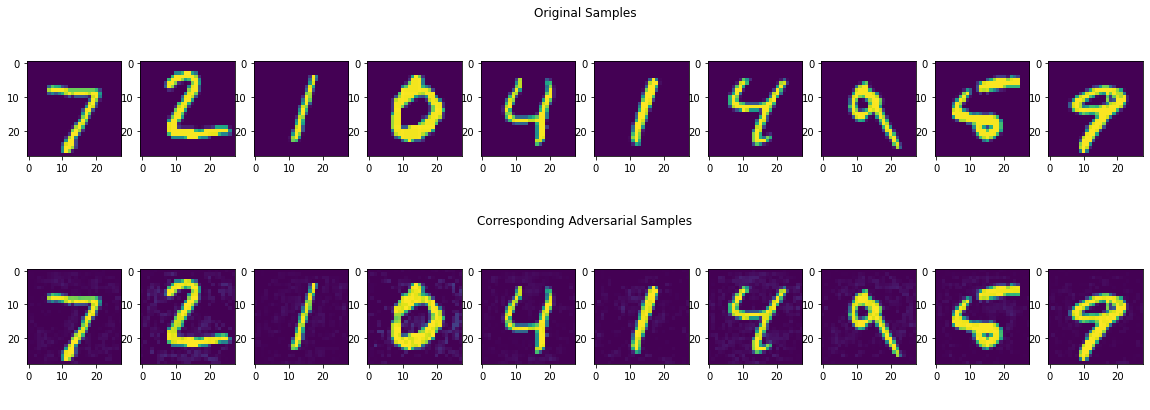

In [ ]:
#Show ten original samples and their corresponding adversarial samples
fig, axes = plt.subplots(2, 10, figsize=(20, 7))
grids = plt.GridSpec(2, 1)
titles = ['Original Samples', 'Corresponding Adversarial Samples']

for i in range(2):
  row = fig.add_subplot(grids[i])
  row.set_title(titles[i])
  row.set_axis_off()

for i in range(10):
  axes[0][i].imshow(data_test[i].reshape(28, 28))
  axes[1][i].imshow(deep_fool_adversarial_data_test[i].reshape(28, 28))

In [ ]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = deep_fool.generate_np(data_train, **deep_fool_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph
AE = autoencoder()
AE.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

AE_metadata = AE.fit(df_attack_data_train, data_train,
                     epochs=50,
                     batch_size=256,
                     shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0377 - accuracy: 0.0106
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0124 - accuracy: 0.0115
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0087 - accuracy: 0.0119
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0070 - accuracy: 0.0126
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0060 - accuracy: 0.0124
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0052 - accuracy: 0.0128
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0046 - accuracy: 0.0131
Epoch 8/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0042 - accuracy: 0.0129
Epoch 9/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0039 - accuracy: 0.0133
Epoch 10/50
60000/60000 [==============================

In [ ]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
denoised_samples = AE.predict(deep_fool_adversarial_data_test)

#Evaluate accuracy of FGM samples after denoising 
denoised_score = classifier.evaluate(denoised_samples, labels_test)
print(f'Testing accuracy on denoised perturbed images: {denoised_score[1]*100}%')

10000/10000 [==============================] - 1s 61us/step
Testing accuracy on denoised perturbed images: 97.57999777793884%


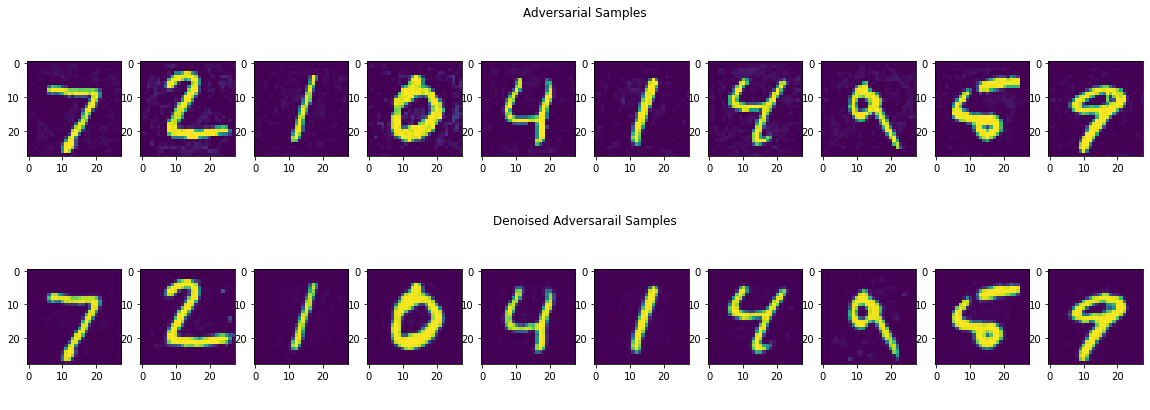

In [ ]:
#Show ten samples of adversarial samples after denoising
fig, axes = plt.subplots(2, 10, figsize=(20, 7))
grids = plt.GridSpec(2, 1)
titles = ['Adversarial Samples', 'Denoised Adversarail Samples']

for i in range(2):
  row = fig.add_subplot(grids[i])
  row.set_title(titles[i])
  row.set_axis_off()

for i in range(10):
  axes[0][i].imshow(deep_fool_adversarial_data_test[i].reshape(28, 28))
  axes[1][i].imshow(denoised_samples[i].reshape(28, 28))